$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Finite Dimensional Koopman Bilinear System

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1 + \mb f_2(\mb x) u_2, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} x_3 \\ x_4 \\ \lambda x_3 \\ \mu x_4 + (2 \lambda - \mu) c x_3^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \qquad
\mb f_2(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ x_1+1 \end{bmatrix}, 
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [q_1 \, q_2 \, \dot{q_1} \, \dot{q_2}]^T$, 
these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield



\begin{equation}
\mb D(\mb q) = \begin{bmatrix} 1 & 0\\ 0 &  \frac{1}{q_1+1} \end{bmatrix}, 
\qquad \mb C(\mb q, \mb{\dot{q}}) = -\begin{bmatrix} \lambda & 0 \\ \frac{1}{q_1 + 1}(2 \lambda - \mu) c \dot{q}_1 & \frac{1}{q_1 +1} \mu \end{bmatrix}, \qquad 
\mb G(\mb q) = \begin{bmatrix} 0 \\ 0 \end{bmatrix} 
\qquad \mb B = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix},
\end{equation}

In [1]:
import numpy as np
import sys
sys.path.append('../../../')

# Define experiment parameters

In [2]:
from core.dynamics import RoboticDynamics

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])
    
class FiniteDimKoopSysDiscrete(FiniteDimKoopSys):
    def __init__(self, lambd, mu, c, dt):
        FiniteDimKoopSys.__init__(self, lambd, mu, c)
        self.dt = dt

    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        lambd, mu, c = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 1, 0],
                                            [0, 0, 0, 1],
                                            [0, 0, lambd, 0],
                                            [u0[1], 0, 2*(2*lambd-mu)*c*x0[2], mu]])

        B_lin = self.dt*np.array([[0, 0],
                          [0, 0],
                          [1, 0],
                          [0, x0[0]+1]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin

n, m = 4, 2
lambd, mu, c = .3, .2, -.5
finite_dim_koop_sys = FiniteDimKoopSys(lambd, mu, c)

In [3]:
from koopman_core.dynamics import LinearLiftedDynamics

A_lin = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, lambd, 0],
                  [0, 0, 0, mu]])
B_lin = np.array([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
dt = 1e-2
linearized_sys = LinearLiftedDynamics(A_lin, B_lin, np.eye(n), lambda x: x)

# MPC parameters:
umax = np.array([7.5, 7.5])
umin = -umax
xmax = np.array([6., 6., 5., 5.])
xmin = -xmax
Q_mpc = 1*np.diag([1, 1, 1e-1, 1e-1])
QN_mpc = 1e4*np.eye(n)
R_mpc = np.eye(m)
traj_duration = 2
traj_length = int(traj_duration/dt)

# Design trajectory:
x0 = np.array([0., 0., 0., 0.])
set_pt = np.array([5., 3., 0., 0.])
term_constraint = False

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0, set_pt, int(traj_length)+1)
u_init = np.zeros((m,traj_length)).T

# Construct Koopman bilinear form of the system

As a result of the careful construction of this system, there exists a Koopman canonical transform, $\mb z = T(\mb x)$ that exactly transforms the control-affine dynamics into a bilinear system. Consider the transformation:

\begin{equation}
    T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 
    \phi_1(\mb q, \mb{\dot{q}})\\
    \phi_2(\mb q, \mb{\dot{q}})\\
    \phi_3(\mb q, \mb{\dot{q}})\\
    \phi_4(\mb q, \mb{\dot{q}})\\
    \phi_5(\mb q, \mb{\dot{q}})\\
    \phi_6(\mb q, \mb{\dot{q}})\\
    \end{bmatrix}
    = \begin{bmatrix} 
    1\\
    q_1 - \frac{1}{\lambda}\dot{q}_1\\
    q_2 - \frac{1}{\mu} \dot{q}_2 + \frac{(2 \lambda - \mu)c}{2\lambda \mu} \dot{q}_1^2\\
    \dot{q}_1\\
    \dot{q}_2 - c \dot{q}_1^2\\
    \dot{q}_1^2\\
    \end{bmatrix},
\end{equation}

where $\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are eigenfunctions of the Koopman operator associated with the drift 
vector field $\mb f_0$. The matrix with the eigenvalue associated with the i-th eigenfunction on the i-th diagonal 
element is $F=\text{diag}(0, 0, \lambda, \mu, 2 \lambda, 0)$. Then, to reformulate the dynamics we have: 

\begin{equation} 
L_{\mb f_1} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0\\ -\frac{1}{\lambda}\\ \frac{(2\lambda - \mu)c}{\lambda \mu}\dot{q}_1\\ 1 \\ -2c\dot{q}_1 \\ 2\dot{q_1} \end{bmatrix}, \qquad 
L_{\mb f_2} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0 \\ 0\\ -\frac{1}{\mu}(q_1 + 1)\\0 \\ q_1 + 1 \\ 0 \end{bmatrix} 
\end{equation}

and the dynamics can be equivalently transformed to a bilinear form $\mb{\dot{z}} = F \mb z + G_1\mb z u_1 + G_2\mb z u_2$ with 

\begin{equation}
F = \begin{bmatrix} 
0 &0 & 0 & 0 & 0 & 0\\  
0 & 0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & \lambda & 0 & 0\\
0 &0 & 0 & 0 & \mu & 0 \\
0 &0 & 0 & 0 & 0 & 2 \lambda\\
\end{bmatrix}, \qquad 
G_1 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
-\frac{1}{\lambda}& 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \frac{(2\lambda - \mu)c}{\lambda \mu} & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & -2c & 0 & 0\\
0 & 0 & 0 & 2 & 0 & 0\\  
\end{bmatrix}
, \qquad 
G_2 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 &  0 & 0 & 0 & 0\\
 -\frac{1}{\mu} & -\frac{1}{\mu} & 0 &  -\frac{1}{\lambda \mu} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & \frac{1}{\lambda} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
\end{equation}

In [4]:
from koopman_core.dynamics import BilinearLiftedDynamics

F = np.array([[0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, lambd, 0, 0],
              [0, 0, 0, 0, mu, 0],
              [0, 0, 0, 0, 0, 2*lambd]])
G_1 = np.array([[0, 0, 0, 0, 0, 0],
                [-1/lambd, 0, 0, 0, 0, 0],
                [0, 0, 0, (2*lambd - mu)*c/(lambd*mu), 0, 0],
                [1, 0, 0, 0, 0, 0], 
                [0, 0, 0, -2*c, 0, 0], 
                [0, 0, 0, 2, 0, 0]])
G_2 = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [-1/mu, -1/mu, 0, -1/(lambd*mu), 0, 0],
                [0, 0, 0, 0, 0, 0], 
                [1, 1, 0, 1/lambd, 0, 0], 
                [0, 0, 0, 0, 0, 0]])
G = [G_1, G_2]
phi_fun = lambda x: np.array([1,
                            x[0,0] - 1/lambd*x[0,2],
                            x[0,1] - 1/mu*x[0,3] + (2*lambd - mu)*c/(2*lambd*mu)*x[0,2]**2,
                            x[0,2],
                            x[0,3] - c*x[0,2]**2,
                            x[0,2]**2])
phi_fun_grad = lambda x: np.array([[0., 0., 0., 0.]
                                   [1., 0., -1/lambd, 0.],
                                   [0., 1., (2*lambd-mu)*c/(lambd*mu)*x[0,2], -1/mu],
                                   [0., 0., 1., 0.],
                                   [0., 0., -2*c*x[0,2], 1.],
                                   [0., 0., 2*x[0,2], 0.]])

C_q = np.array([[0, 1, 0, 1/lambd, 0, 0],
                [0, 0, 1, 0, 1/mu, c/mu - ((2*lambd - mu)*c)/(2*lambd*mu)]])
C_qdot = np.array([[0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, c]])
C = np.concatenate((C_q, C_qdot), axis=0)
n_koop = 6

koop_bilinear_sys = BilinearLiftedDynamics(n_koop, m, F, G, C, phi_fun)

#### Verify that the Koopman Bilinear Form model and control-affine model are equivalent

To verify that the models are in fact equivalent we sample a random control sequence and simulate both models forward with the same control sequence. As can be seen below, the resulting trajectories are equivalent.

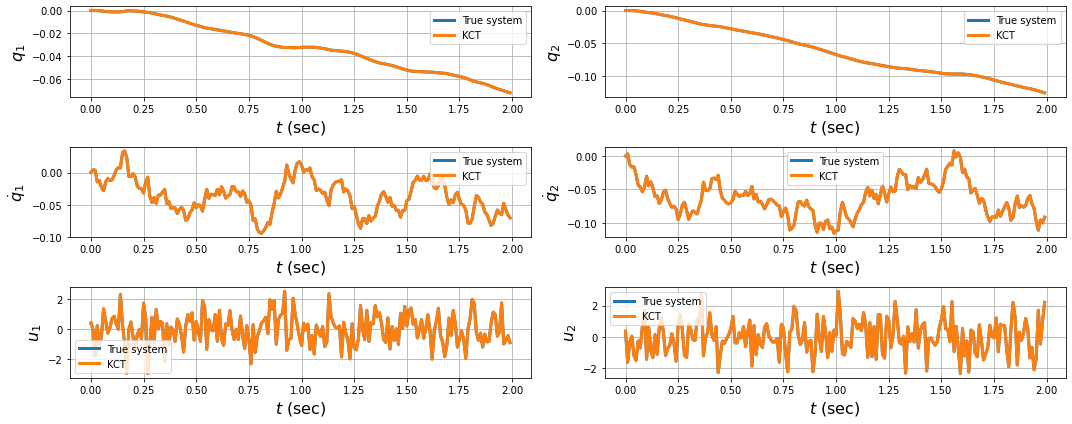

In [5]:
from matplotlib.pyplot import subplots, tight_layout, show
from koopman_core.controllers.openloop_controller import OpenLoopController

ol_controller = OpenLoopController(finite_dim_koop_sys, np.random.normal(size=(2,200)).T, np.arange(0,200)*dt)
z0 = phi_fun(x0.reshape((1,-1)))
xs, us = finite_dim_koop_sys.simulate(x0, ol_controller, np.arange(0,201)*dt)
zs_koop, us_koop = koop_bilinear_sys.simulate(z0, ol_controller, np.arange(0,201)*dt)
xs_koop = np.dot(C, zs_koop.T)

_, axs = subplots(3, 2, figsize=(15, 6))
ylabels = ['$q_1$', '$q_2$', '$\\dot{q}_1$', '$\\dot{q}_2$', '$u_1$', '$u_2$']

for ax, data_fb, data_koop, ylabel in zip(axs.flatten(), np.vstack((xs[:-1,:].T, us.T)), np.vstack((xs_koop[:,:-1], us_koop.T)), ylabels):
    ax.plot(np.arange(0,200)*dt, data_fb, linewidth=3, label='True system')
    ax.plot(np.arange(0,200)*dt, data_koop, linewidth=3, label='KCT')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)
    ax.legend()
    
tight_layout()
show()

# Design model predictive controllers

In [6]:
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = True
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 4000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

#### Linear model predictive controller

In [7]:
from koopman_core.controllers import MPCController

controller_lmpc = MPCController(linearized_sys, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint, add_slack=True)

#### Bilinear model predictive controller

In [8]:
from koopman_core.controllers import NonlinearMPCController, BilinearMPCController

# Define rough discrete-time model:
A_d = np.eye(n_koop) + koop_bilinear_sys.A*dt
B_d = [b*dt for b in koop_bilinear_sys.B]
kbf_d = BilinearLiftedDynamics(n_koop, m, A_d, B_d, C, koop_bilinear_sys.basis, continuous_mdl=False, dt=dt)

# Define kbf controller:
controller_knmpc = BilinearMPCController(kbf_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, solver_settings, terminal_constraint=term_constraint)
z0 = phi_fun(x0.reshape((1,-1)))
z_init = np.array([phi_fun(x.reshape((1,-1))) for x in x_init])
controller_knmpc.construct_controller(z_init, u_init)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1606, constraints m = 2410
          nnz(P) + nnz(A) = 15235
settings: linear system solver = qdldl,
          eps_abs = 1.0e-06, eps_rel = 1.0e-06,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off



#### Nonlinear model predictive controller

In [9]:
finite_dim_koop_sys_d = FiniteDimKoopSysDiscrete(lambd, mu, c, dt)
controller_nmpc = NonlinearMPCController(finite_dim_koop_sys_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, solver_settings, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1204, constraints m = 2008
          nnz(P) + nnz(A) = 8218
settings: linear system solver = qdldl,
          eps_abs = 1.0e-06, eps_rel = 1.0e-06,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off



# Evaluate performance of controllers for trajectory generation

#### Design trajectories with the constructed MPCs

In [10]:
max_iter = 50

controller_lmpc.eval(x0, 0)
xr_lmpc = controller_lmpc.parse_result()
ur_lmpc = controller_lmpc.get_control_prediction()

controller_knmpc.solve_to_convergence(z0, 0., z_init, u_init, max_iter=max_iter)
xr_knmpc = koop_bilinear_sys.C@controller_knmpc.get_state_prediction().T
ur_knmpc = controller_knmpc.get_control_prediction().T

controller_nmpc.solve_to_convergence(x0, 0., x_init, u_init, max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

iter   objective    pri res    dua res    rho        time
   1  -1.0223e+03   1.23e-01   2.90e+01   1.00e-01   2.90e-03s
 200   2.0231e+03   6.93e-03   2.98e-01   1.00e-01   1.87e-02s
 400   2.2488e+03   5.27e-04   2.16e-02   1.00e-01   3.22e-02s
 600   2.2662e+03   4.28e-05   1.73e-03   1.00e-01   4.60e-02s
 750   2.2675e+03   6.55e-06   2.65e-04   1.00e-01   5.62e-02s
plsh   2.2677e+03   1.89e-10   1.28e-08   --------   5.77e-02s

status:               solved
solution polish:      successful
number of iterations: 750
optimal objective:    2267.7350
run time:             5.77e-02s
optimal rho estimate: 2.16e-01

iter   objective    pri res    dua res    rho        time
   1   1.4934e+04   5.81e+00   1.40e+03   1.00e-01   1.34e-03s
 200   4.2922e+02   1.76e-03   6.09e-01   1.00e-01   1.84e-02s
 400   1.5115e+02   5.84e-05   3.07e-02   1.00e-01   3.41e-02s
 600   1.3729e+02   2.90e-06   1.52e-03   1.00e-01   4.78e-02s
 625   1.3707e+02   1.98e-06   1.03e-03   1.00e-01   5.01e-02s
plsh  

/Users/carlaxelfolkestad/OneDrive - California Institute of Technology/Research/Learning to fly/Code/koopman-learning-control/koopman_core/controllers/nonlinear_mpc_controller.py:162: RuntimeWarning: divide by zero encountered in double_scalars
  while (iter == 0 or np.linalg.norm(u_prev - self.cur_u) / np.linalg.norm(u_prev) > eps) and iter < max_iter:


iter   objective    pri res    dua res    rho        time
   1  -1.0071e+03   2.68e-01   1.13e+01   1.00e-01   1.72e-03s
 200   2.1735e+03   4.66e-03   2.20e-02   1.00e-01   9.94e-03s
 400   2.2648e+03   1.48e-04   6.78e-04   1.00e-01   2.11e-02s
 575   2.2676e+03   7.33e-06   3.36e-05   1.00e-01   3.26e-02s
plsh   2.2677e+03   1.33e-10   1.25e-09   --------   3.41e-02s

status:               solved
solution polish:      successful
number of iterations: 575
optimal objective:    2267.7350
run time:             3.41e-02s
optimal rho estimate: 3.03e-01

iter   objective    pri res    dua res    rho        time
   1   3.1155e+04   1.91e+01   9.59e+02   1.00e-01   1.02e-03s
 175   1.3978e+02   2.12e-07   8.60e-06   1.00e-01   8.77e-03s
plsh   1.3977e+02   9.89e-14   6.79e-12   --------   1.00e-02s

status:               solved
solution polish:      successful
number of iterations: 175
optimal objective:    139.7744
run time:             1.00e-02s
optimal rho estimate: 1.42e-01

iter   obje

#### Simulate designed trajectories open-loop

In [11]:
from koopman_core.controllers import OpenLoopController
t_eval = np.arange(0,traj_length+1)*dt
ol_controller_lmpc = OpenLoopController(finite_dim_koop_sys, ur_lmpc.T, t_eval[:-1])
xs_lmpc, us_lmpc = finite_dim_koop_sys.simulate(x0, ol_controller_lmpc, t_eval)
xs_lmpc, us_lmpc = xs_lmpc.T, us_lmpc.T

ol_controller_knmpc = OpenLoopController(finite_dim_koop_sys, ur_knmpc.T, t_eval[:-1])
xs_knmpc, us_knmpc = finite_dim_koop_sys.simulate(x0, ol_controller_knmpc, t_eval)
xs_knmpc, us_knmpc = xs_knmpc.T, us_knmpc.T

ol_controller_nmpc = OpenLoopController(finite_dim_koop_sys, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = finite_dim_koop_sys.simulate(x0, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

#### Plot/analyze the results

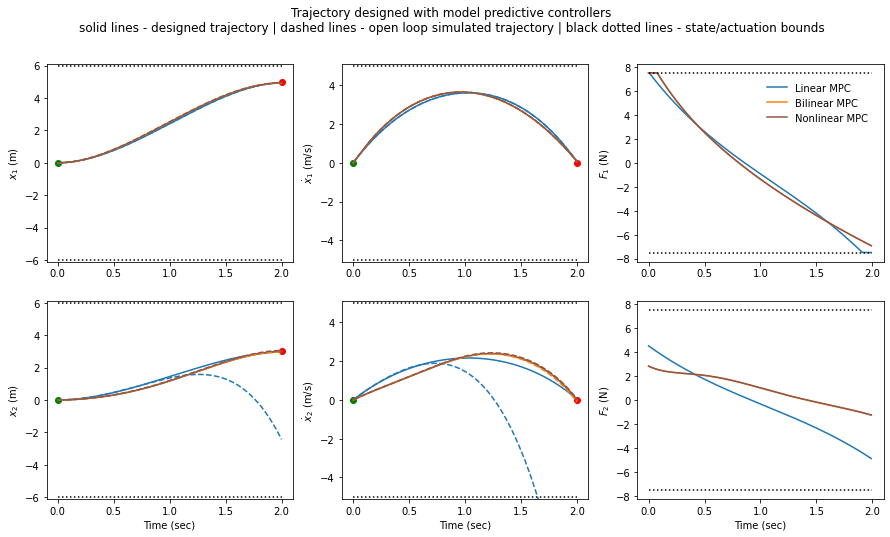

Quadratic cost (normalized by NMPC cost) of designed and realized trajectories designed with each MPC:

                        Designed trajectory    Realized trajectory
--------------------  ---------------------  ---------------------
Linear MPC                         1.20397               510.693
Koopman bilinear MPC               0.998741                1.01581
Nonlinear MPC                      1                       1


In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate

plot_inds = [0, 2, 1, 3, 0, 1]
subplot_inds = [1, 2, 4, 5, 3, 6]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown']

plt.figure(figsize=(15,8))
plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval, xr_lmpc[ind,:], colors[0], label='Linear MPC')
        plt.plot(t_eval, xr_knmpc[ind, :], colors[1], label='Bilinear MPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[2], label='Nonlinear MPC')

        plt.plot(t_eval, xs_lmpc[ind,:], '--', color=colors[0])
        plt.plot(t_eval, xs_knmpc[ind, :], '--', color=colors[1])
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[2])

        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
    else:
        ax = plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_lmpc[ind,:], color=colors[0], label='Linear MPC')
        plt.plot(t_eval[:-1], ur_knmpc[ind, :], color=colors[1], label='Bilinear MPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[2], label='Nonlinear MPC')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii]==3:
            plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.95), frameon=False)
    if subplot_inds[ii] == 4 or subplot_inds[ii] == 5 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')
            
plt.show()

cost_ref_lmpc = (xr_lmpc[:,-1]-set_pt).T@QN_mpc@(xr_lmpc[:,-1]-set_pt) + np.sum(np.diag(ur_lmpc.T@R_mpc@ur_lmpc))
cost_ref_knmpc = (xr_knmpc[:,-1]-set_pt).T@QN_mpc@(xr_knmpc[:,-1]-set_pt) + np.sum(np.diag(ur_knmpc.T@R_mpc@ur_knmpc))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt).T@QN_mpc@(xr_nmpc[:,-1]-set_pt) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

cost_ol_lmpc = (xs_lmpc[:,-1]-set_pt).T@QN_mpc@(xs_lmpc[:,-1]-set_pt) + np.sum(np.diag(ur_lmpc.T@R_mpc@ur_lmpc))
cost_ol_knmpc = (xs_knmpc[:,-1]-set_pt).T@QN_mpc@(xs_knmpc[:,-1]-set_pt) + np.sum(np.diag(ur_knmpc.T@R_mpc@ur_knmpc))
cost_ol_nmpc = (xs_nmpc[:,-1]-set_pt).T@QN_mpc@(xs_nmpc[:,-1]-set_pt) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

print('Quadratic cost (normalized by NMPC cost) of designed and realized trajectories designed with each MPC:\n')
print(tabulate([['Linear MPC', cost_ref_lmpc/cost_ref_nmpc, cost_ol_lmpc/cost_ol_nmpc], 
                ['Koopman bilinear MPC', cost_ref_knmpc/cost_ref_nmpc, cost_ol_knmpc/cost_ol_nmpc],
                ['Nonlinear MPC', 1, 1]], 
               headers=['Designed trajectory', 'Realized trajectory']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

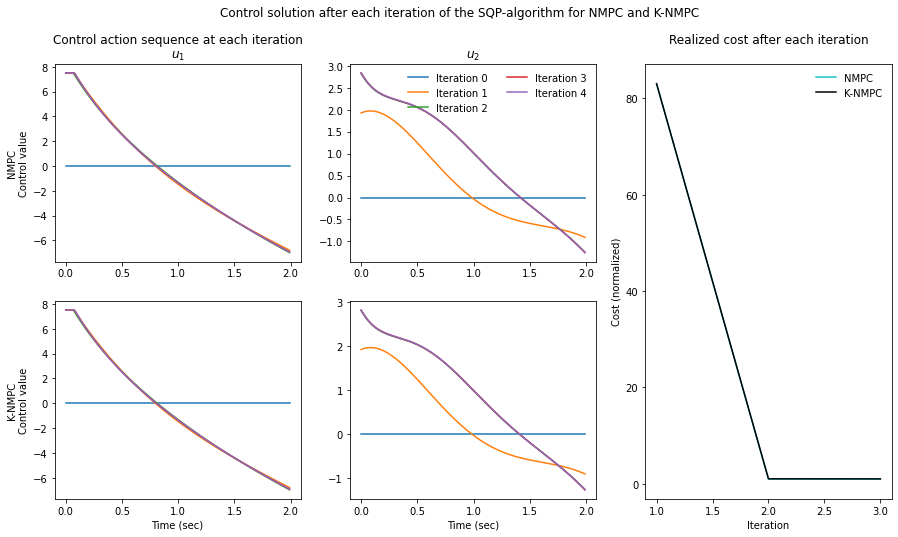

Solution statistics

                        Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                           iterations       iteration (secs)      iteration (secs)    time (secs)
--------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                       4              0.0492686            0.00777309       0.197074
Koopman bilinear MPC                4              0.0501276            0.00784788       0.200511


In [13]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_knmpc.x_iter))

# Calculate cost after each iteration:
iter_cost_nmpc, iter_cost_knmpc = [], []

ol_controller_init = OpenLoopController(finite_dim_koop_sys, u_init, t_eval[:-1])
xs_init, _ = finite_dim_koop_sys.simulate(x0, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T
init_cost = (xs_init[:,-1]-set_pt).T@QN_mpc@(xs_init[:,-1]-set_pt) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_nmpc = [init_cost]
iter_cost_knmpc = [init_cost]

for ii in range(n_iter):
    ur_knmpc_iter = controller_knmpc.u_iter[ii].T
    ol_controller_knmpc_iter = OpenLoopController(finite_dim_koop_sys, ur_knmpc_iter, t_eval[:-1])
    xs_knmpc_iter, _ = finite_dim_koop_sys.simulate(x0, ol_controller_knmpc_iter, t_eval)
    xs_knmpc_iter, us_knmpc_iter = xs_knmpc_iter.T, ur_knmpc_iter.T
    iter_cost_knmpc.append((xs_knmpc_iter[:,-1]-set_pt).T@QN_mpc@(xs_knmpc_iter[:,-1]-set_pt) + np.sum(np.diag(us_knmpc_iter.T@R_mpc@us_knmpc_iter)))
    
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(finite_dim_koop_sys, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = finite_dim_koop_sys.simulate(x0, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))

plt.figure(figsize=(15,8))
plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
ax1 = plt.subplot(2,3,1)
ax1.plot(t_eval[:-1],u_init[:, 0])
ax2 = plt.subplot(2,3,2)
ax2.plot(t_eval[:-1],u_init[:, 1], label='Iteration 0')
ax3 = plt.subplot(2,3,4)
ax3.plot(t_eval[:-1],u_init[:, 0])
ax4 = plt.subplot(2,3,5)
ax4.plot(t_eval[:-1],u_init[:, 0])

for it in range(n_iter):
    ax1.plot(t_eval[:-1],controller_nmpc.u_iter[it][0,:])
    ax2.plot(t_eval[:-1],controller_nmpc.u_iter[it][1,:], label='Iteration '+str(it+1))
    ax3.plot(t_eval[:-1],controller_knmpc.u_iter[it][0,:])
    ax4.plot(t_eval[:-1],controller_knmpc.u_iter[it][1,:])
    
ax5 = plt.subplot(1,3,3)
ax5.plot(np.arange(1,n_iter), iter_cost_nmpc[1:n_iter]/iter_cost_nmpc[-1], 'tab:cyan', label='NMPC')
ax5.plot(np.arange(1,n_iter), iter_cost_knmpc[1:n_iter]/iter_cost_nmpc[-1], 'k', label='K-NMPC')

ax1.set_title('Control action sequence at each iteration\n$u_1$')
ax1.set_ylabel('NMPC\nControl value')
ax2.set_title('$u_2$')
ax2.legend(ncol=2, loc='upper right', frameon=False)
ax3.set_ylabel('K-NMPC\nControl value')
ax3.set_xlabel('Time (sec)')
ax4.set_xlabel('Time (sec)')
ax5.set_title('Realized cost after each iteration\n')
ax5.set_xlabel('Iteration')
ax5.set_ylabel('Cost (normalized)')
ax5.legend(loc='upper right', frameon=False)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_knmpc.x_iter), np.mean(controller_knmpc.comp_time), np.std(controller_knmpc.comp_time), sum(controller_knmpc.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [14]:
Q_mpc_cl = 1e2*np.diag([1, 1, 1e-1, 1e-1])
QN_mpc_cl= Q_mpc_cl
R_mpc_cl = np.eye(m)
traj_duration = 0.5
N_cl = int(traj_duration/dt)
max_iter_sqp = 100

solver_settings_cl = solver_settings

In [15]:
controller_lmpc_cl = MPCController(linearized_sys, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=False, add_slack=False)
controller_knmpc_cl = BilinearMPCController(kbf_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, solver_settings_cl, terminal_constraint=False, add_slack=False)
controller_knmpc_cl.construct_controller(controller_knmpc.cur_z[:N_cl+1,:], controller_knmpc.cur_u[:N_cl,:])

controller_nmpc_cl = NonlinearMPCController(finite_dim_koop_sys_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, solver_settings_cl, terminal_constraint=False, add_slack=False)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 406, constraints m = 610
          nnz(P) + nnz(A) = 3835
settings: linear system solver = qdldl,
          eps_abs = 1.0e-06, eps_rel = 1.0e-06,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2

In [16]:
controller_knmpc_cl.solve_to_convergence(z0, 0., controller_knmpc.cur_z[:N_cl+1,:], controller_knmpc.cur_u[:N_cl,:], max_iter=max_iter_sqp)
controller_nmpc_cl.solve_to_convergence(x0, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter_sqp)
#controller_knmpc_cl.solve_to_convergence(z0, 0., z_init[:N_cl+1,:], u_init[:N_cl,:], max_iter=max_iter_sqp)
#controller_nmpc_cl.solve_to_convergence(x0, 0., x_init[:N_cl+1,:], u_init[:N_cl,:], max_iter=max_iter_sqp)
controller_knmpc_cl.comp_time, controller_knmpc_cl.prep_time, controller_knmpc_cl.qp_time,  = [], [], []
controller_nmpc_cl.comp_time, controller_nmpc_cl.prep_time, controller_nmpc_cl.qp_time,  = [], [], []

iter   objective    pri res    dua res    rho        time
   1  -5.0454e+04   3.00e-01   9.11e+02   1.00e-01   1.25e-03s
 200  -1.6317e+03   2.87e-04   4.31e-01   1.00e-01   6.20e-03s
 275  -1.6350e+03   3.80e-06   7.20e-04   1.51e-02   8.14e-03s
plsh  -1.6351e+03   1.25e-12   3.43e-08   --------   8.83e-03s

status:               solved
solution polish:      successful
number of iterations: 275
optimal objective:    -1635.0818
run time:             8.83e-03s
optimal rho estimate: 1.34e-02

iter   objective    pri res    dua res    rho        time
   1  -9.6788e+03   3.11e+00   4.17e+03   1.51e-02   6.94e-04s
 200   1.4271e+01   6.17e-04   1.38e-01   4.06e-01   5.79e-03s
 400  -3.2758e+00   9.04e-05   4.12e+00   3.36e+00   1.10e-02s
 600  -1.8193e+00   2.83e-05   1.73e+00   3.36e+00   1.56e-02s
 800   2.5148e+00   1.47e-04   1.95e-01   6.31e-01   2.03e-02s
1000  -1.8965e+00   3.04e-05   7.65e-02   6.31e-01   2.39e-02s
1200  -1.0648e+00   2.08e-06   3.38e-02   6.31e-01   2.82e-02s
1400 

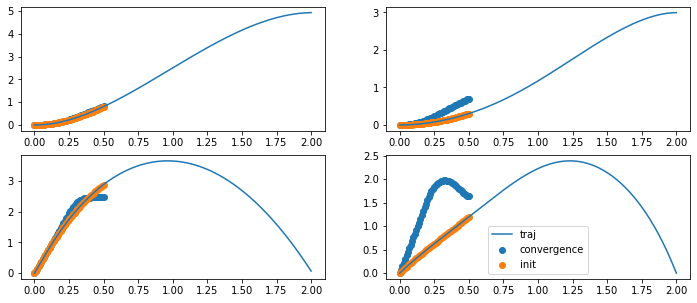

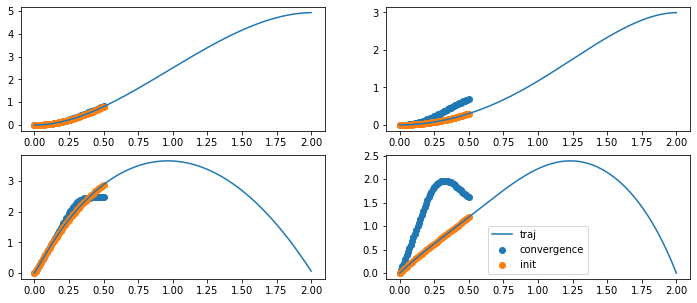

In [17]:
x_ex = controller_knmpc_cl.get_state_prediction()@koop_bilinear_sys.C.T
x_ex_org = controller_knmpc.get_state_prediction()@koop_bilinear_sys.C.T
x_init = controller_knmpc.cur_z[:N_cl+1,:]@koop_bilinear_sys.C.T
plt.figure(figsize=(12,5))
for ii in range(4):
    plt.subplot(2,2, ii+1)
    plt.scatter(t_eval[:51], x_ex[:,ii], label='convergence')
    plt.scatter(t_eval[:51], x_init[:,ii], label='init')
    plt.plot(t_eval, x_ex_org[:201,ii], label='traj')
plt.legend()
plt.show()

x_ex = controller_nmpc_cl.get_state_prediction()
x_ex_org = controller_nmpc.get_state_prediction()
x_init = controller_nmpc.cur_z[:N_cl+1,:]
plt.figure(figsize=(12,5))
for ii in range(4):
    plt.subplot(2,2, ii+1)
    plt.scatter(t_eval[:51], x_ex[:,ii], label='convergence')
    plt.scatter(t_eval[:51], x_init[:,ii], label='init')
    plt.plot(t_eval, x_ex_org[:201,ii], label='traj')
plt.legend()
plt.show()

# TODOs:
# - why is 1 not const in bEDMD model? -> override_kinematics?
# - why is cl and traj gen completely different?

In [18]:
solver_settings_cl['polish'] = False
solver_settings_cl['check_termination'] = 5
solver_settings_cl['max_iter'] = 5
solver_settings_cl['eps_abs'] = 1e-2
solver_settings_cl['eps_rel'] = 1e-2
solver_settings['eps_prim_inf'] = 1e-3
solver_settings['eps_dual_inf'] = 1e-3
controller_nmpc_cl.update_solver_settings(solver_settings_cl)
controller_knmpc_cl.update_solver_settings(solver_settings_cl)

#### Simulate designed trajectories closed-loop

In [19]:
xs_lmpc_cl, us_lmpc_cl = finite_dim_koop_sys.simulate(x0, controller_lmpc_cl, t_eval)
xs_lmpc_cl, us_lmpc_cl = xs_lmpc_cl.T, us_lmpc_cl.T

controller_knmpc_cl.comp_time = []
xs_knmpc_cl, us_knmpc_cl = finite_dim_koop_sys.simulate(x0, controller_knmpc_cl, t_eval)
xs_knmpc_cl, us_knmpc_cl = xs_knmpc_cl.T, us_knmpc_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = finite_dim_koop_sys.simulate(x0, controller_nmpc_cl, t_eval)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

iter   objective    pri res    dua res    rho        time
   1   8.2020e+01   3.75e-01   1.24e+06   6.97e-01   4.25e-04s
  60   4.4212e+02   9.11e-03   1.59e+01   6.97e-01   2.19e-03s

status:               solved
number of iterations: 60
optimal objective:    442.1177
run time:             2.62e-03s
optimal rho estimate: 5.11e-01

iter   objective    pri res    dua res    rho        time
   1   4.4598e+02   4.02e-01   1.38e+06   6.97e-01   5.27e-04s
  30   2.1074e+02   1.12e-02   3.33e+00   6.97e-01   1.20e-03s

status:               solved
number of iterations: 30
optimal objective:    210.7393
run time:             1.27e-03s
optimal rho estimate: 1.04e+00

iter   objective    pri res    dua res    rho        time
   1   2.8201e+02   3.45e-01   1.11e+04   6.97e-01   4.56e-04s
  30   5.2837e+01   1.18e-02   8.74e+00   6.97e-01   1.10e-03s

status:               solved
number of iterations: 30
optimal objective:    52.8370
run time:             1.20e-03s
optimal rho estimate: 1.68e+00


  20  -3.7909e+00   1.53e-04   8.62e+00   6.97e-01   1.07e-03s

status:               solved
number of iterations: 20
optimal objective:    -3.7909
run time:             1.42e-03s
optimal rho estimate: 2.73e-01

iter   objective    pri res    dua res    rho        time
   1   2.2581e+01   4.82e-02   1.45e+05   6.97e-01   6.05e-04s
  20  -3.5058e+00   1.48e-04   8.08e+00   6.97e-01   1.59e-03s

status:               solved
number of iterations: 20
optimal objective:    -3.5058
run time:             2.24e-03s
optimal rho estimate: 2.73e-01

iter   objective    pri res    dua res    rho        time
   1   1.5993e+01   4.64e-02   1.36e+05   6.97e-01   5.77e-04s
  20  -3.2764e+00   1.42e-04   7.53e+00   6.97e-01   1.17e-03s

status:               solved
number of iterations: 20
optimal objective:    -3.2764
run time:             1.28e-03s
optimal rho estimate: 2.73e-01

iter   objective    pri res    dua res    rho        time
   1   1.2345e+01   4.47e-02   1.28e+05   6.97e-01   6.63e-04s
 

iter   objective    pri res    dua res    rho        time
   1   3.8323e+00   9.62e-03   1.03e+04   6.97e-01   7.00e-04s
  20   1.2419e+00   3.14e-05   4.94e-01   6.97e-01   1.26e-03s

status:               solved
number of iterations: 20
optimal objective:    1.2419
run time:             1.64e-03s
optimal rho estimate: 3.17e-01

iter   objective    pri res    dua res    rho        time
   1   4.3704e+00   9.07e-03   9.17e+03   6.97e-01   6.65e-04s
  20   6.9147e-01   2.64e-05   4.26e-01   6.97e-01   1.29e-03s

status:               solved
number of iterations: 20
optimal objective:    0.6915
run time:             1.68e-03s
optimal rho estimate: 3.14e-01

iter   objective    pri res    dua res    rho        time
   1   3.8709e+00   8.73e-03   8.63e+03   6.97e-01   5.73e-04s
  20   7.1813e-01   2.54e-05   4.02e-01   6.97e-01   1.27e-03s

status:               solved
number of iterations: 20
optimal objective:    0.7181
run time:             1.91e-03s
optimal rho estimate: 3.12e-01

iter

iter   objective    pri res    dua res    rho        time
   1  -3.8413e-01   1.03e-03   2.66e+02   6.97e-01   4.12e-04s
  15   3.0674e-02   2.72e-05   1.30e-01   6.97e-01   8.61e-04s

status:               solved
number of iterations: 15
optimal objective:    0.0307
run time:             9.37e-04s
optimal rho estimate: 3.15e-01

iter   objective    pri res    dua res    rho        time
   1  -4.4121e-01   1.03e-03   2.58e+02   6.97e-01   6.58e-04s
  15   2.4554e-02   2.70e-05   1.24e-01   6.97e-01   1.16e-03s

status:               solved
number of iterations: 15
optimal objective:    0.0246
run time:             1.66e-03s
optimal rho estimate: 3.16e-01

iter   objective    pri res    dua res    rho        time
   1  -4.7201e-01   1.02e-03   2.50e+02   6.97e-01   6.88e-04s
  15   1.8431e-02   2.76e-05   1.17e-01   6.97e-01   1.22e-03s

status:               solved
number of iterations: 15
optimal objective:    0.0184
run time:             1.68e-03s
optimal rho estimate: 3.16e-01

iter

iter   objective    pri res    dua res    rho        time
   1   4.5683e+01   7.49e-02   3.05e+04   8.12e-01   3.29e-04s
  20   5.3597e+02   7.94e-03   2.32e+00   8.12e-01   6.72e-04s

status:               solved
number of iterations: 20
optimal objective:    535.9722
run time:             1.14e-03s
optimal rho estimate: 1.85e+00

iter   objective    pri res    dua res    rho        time
   1   5.9250e+02   2.41e-01   3.06e+04   8.12e-01   3.82e-04s
  20   6.8709e+01   4.47e-03   2.54e+00   8.12e-01   7.60e-04s

status:               solved
number of iterations: 20
optimal objective:    68.7094
run time:             8.13e-04s
optimal rho estimate: 1.13e+00

iter   objective    pri res    dua res    rho        time
   1   8.7063e+01   1.81e-01   4.10e+02   8.12e-01   3.99e-04s
  10  -1.0096e+02   4.98e-03   3.19e+00   8.12e-01   7.19e-04s

status:               solved
number of iterations: 10
optimal objective:    -100.9607
run time:             8.26e-04s
optimal rho estimate: 9.66e-01

iter   objective    pri res    dua res    rho        time
   1   1.8232e+01   2.43e-01   1.03e+03   8.12e-01   6.34e-04s
  15  -1.1197e+01   5.18e-04   5.09e-01   8.12e-01   8.87e-04s

status:               solved
number of iterations: 15
optimal objective:    -11.1971
run time:             1.19e-03s
optimal rho estimate: 4.42e-01

iter   objective    pri res    dua res    rho        time
   1   1.9588e+01   1.09e-02   1.03e+03   8.12e-01   5.39e-04s
  15  -1.4244e+01   4.51e-04   5.08e-01   8.12e-01   9.54e-04s

status:               solved
number of iterations: 15
optimal objective:    -14.2441
run time:             1.07e-03s
optimal rho estimate: 4.09e-01

iter   objective    pri res    dua res    rho        time
   1   1.6766e+01   6.65e-02   1.04e+03   8.12e-01   5.47e-04s
  15  -1.1151e+01   2.40e-04   5.08e-01   8.12e-01   1.03e-03s

status:               solved
number of iterations: 15
optimal objective:    -11.1509
run time:             1.14e-03s
optimal rho estimate: 2.96e-01

iter   objective    pri res    dua res    rho        time
   1   7.4039e+00   1.94e-03   3.91e+02   8.12e-01   3.97e-04s
  15   1.1681e+00   3.01e-05   2.76e-01   8.12e-01   7.67e-04s

status:               solved
number of iterations: 15
optimal objective:    1.1681
run time:             1.09e-03s
optimal rho estimate: 1.62e-01

iter   objective    pri res    dua res    rho        time
   1   7.1633e+00   1.90e-03   3.76e+02   8.12e-01   4.62e-04s
  15   1.1983e+00   2.95e-05   2.68e-01   8.12e-01   8.19e-04s

status:               solved
number of iterations: 15
optimal objective:    1.1983
run time:             9.65e-04s
optimal rho estimate: 1.63e-01

iter   objective    pri res    dua res    rho        time
   1   6.9249e+00   1.86e-03   3.62e+02   8.12e-01   3.74e-04s
  15   1.2211e+00   2.90e-05   2.61e-01   8.12e-01   6.86e-04s

status:               solved
number of iterations: 15
optimal objective:    1.2211
run time:             8.33e-04s
optimal rho estimate: 1.64e-01

iter

iter   objective    pri res    dua res    rho        time
   1   8.7621e-02   6.88e-04   4.76e+01   8.12e-01   8.38e-04s
  10   3.5744e-01   1.10e-04   3.65e-01   8.12e-01   1.09e-03s

status:               solved
number of iterations: 10
optimal objective:    0.3574
run time:             1.15e-03s
optimal rho estimate: 3.33e-01

iter   objective    pri res    dua res    rho        time
   1  -6.5431e-03   6.72e-04   4.49e+01   8.12e-01   4.25e-04s
  10   3.3680e-01   1.07e-04   3.44e-01   8.12e-01   7.83e-04s

status:               solved
number of iterations: 10
optimal objective:    0.3368
run time:             1.07e-03s
optimal rho estimate: 3.37e-01

iter   objective    pri res    dua res    rho        time
   1  -1.0397e-01   6.57e-04   4.23e+01   8.12e-01   5.27e-04s
  10   3.1713e-01   1.05e-04   3.24e-01   8.12e-01   9.29e-04s

status:               solved
number of iterations: 10
optimal objective:    0.3171
run time:             1.10e-03s
optimal rho estimate: 3.41e-01

iter

iter   objective    pri res    dua res    rho        time
   1   1.5227e-01   2.79e-04   3.64e+00   8.12e-01   2.69e-04s
  10  -2.3056e-02   4.10e-05   2.79e-02   8.12e-01   5.17e-04s

status:               solved
number of iterations: 10
optimal objective:    -0.0231
run time:             6.56e-04s
optimal rho estimate: 6.59e-01

iter   objective    pri res    dua res    rho        time
   1   1.2218e-01   2.77e-04   3.45e+00   8.12e-01   3.90e-04s
  10  -2.4651e-02   4.00e-05   2.64e-02   8.12e-01   6.43e-04s

status:               solved
number of iterations: 10
optimal objective:    -0.0247
run time:             7.07e-04s
optimal rho estimate: 6.72e-01

iter   objective    pri res    dua res    rho        time
   1   1.0059e-01   2.74e-04   3.27e+00   8.12e-01   4.21e-04s
  10  -2.5908e-02   3.87e-05   2.50e-02   8.12e-01   6.81e-04s

status:               solved
number of iterations: 10
optimal objective:    -0.0259
run time:             7.48e-04s
optimal rho estimate: 6.85e-01

i

#### Plot/analyze the results

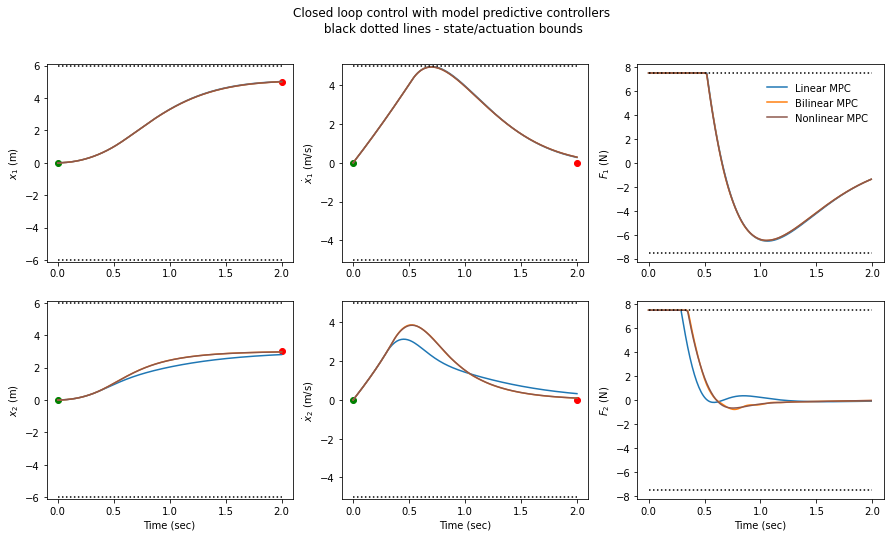


Solution statistics:

                        Quadratic cost    Mean comp. time per    Std comp. time per
                          (normalized)       iteration (secs)      iteration (secs)
--------------------  ----------------  ---------------------  --------------------
Linear MPC                     1.08476             0.00136118           0.000366893
Koopman bilinear MPC           1.00192             0.00286317           0.000750391
Nonlinear MPC                  1                   0.00866539           0.00101997


In [20]:
plot_inds = [0, 2, 1, 3, 0, 1]
subplot_inds = [1, 2, 4, 5, 3, 6]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown']

plt.figure(figsize=(15,8))
plt.suptitle('Closed loop control with model predictive controllers\n black dotted lines - state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval, xs_lmpc_cl[ind,:], colors[0], label='Linear MPC')
        plt.plot(t_eval, xs_knmpc_cl[ind, :], colors[1], label='Bilinear MPC')
        plt.plot(t_eval, xs_nmpc_cl[ind,:], colors[2], label='Nonlinear MPC')
        
        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
    else:
        ax = plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval[:-1],us_lmpc_cl[ind,:], color=colors[0], label='Linear MPC')
        plt.plot(t_eval[:-1], us_knmpc_cl[ind, :], color=colors[1], label='Bilinear MPC')
        plt.plot(t_eval[:-1],us_nmpc_cl[ind,:], color=colors[2], label='Nonlinear MPC')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii]==3:
            plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.95), frameon=False)
    if subplot_inds[ii] == 4 or subplot_inds[ii] == 5 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')
            
plt.show()

cost_cl_lmpc = np.sum(np.diag((xs_lmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_lmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_lmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_lmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_lmpc_cl.T@R_mpc@us_lmpc_cl))
cost_cl_knmpc = np.sum(np.diag((xs_knmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_knmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_knmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_knmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_knmpc_cl.T@R_mpc@us_knmpc_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_nmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_nmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_nmpc_cl.T@R_mpc@us_nmpc_cl))


print('\nSolution statistics:\n')
print(tabulate([['Linear MPC', cost_cl_lmpc/cost_cl_nmpc, np.mean(controller_lmpc_cl.comp_time), np.std(controller_lmpc_cl.comp_time)],
                ['Koopman bilinear MPC', cost_cl_knmpc/cost_cl_nmpc, np.mean(controller_knmpc_cl.comp_time), np.std(controller_knmpc_cl.comp_time)], 
                ['Nonlinear MPC', cost_cl_nmpc/cost_cl_nmpc, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]],
               headers=['Quadratic cost\n(normalized)', 'Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)']))

In [21]:
print('\nSolution time profiling:\n')
print(tabulate([['NMPC', np.mean(controller_nmpc_cl.comp_time), np.mean(controller_nmpc_cl.prep_time), np.mean(controller_nmpc_cl.qp_time)],
                ['Koopman bilinear MPC', np.mean(controller_knmpc_cl.comp_time), np.mean(controller_knmpc_cl.prep_time), np.mean(controller_knmpc_cl.qp_time)]],
               headers=['Total comp time', 'setup time', 'qp solve time' ]))


Solution time profiling:

                        Total comp time    setup time    qp solve time
--------------------  -----------------  ------------  ---------------
NMPC                         0.00866539    0.00709775       0.00156764
Koopman bilinear MPC         0.00286317    0.00113765       0.00172552
